In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, "..")
from stamp import *
from physics_dist414pc import *
# from physics import *
from astropy.stats import sigma_clipped_stats
import re
import os
%load_ext autoreload
%autoreload 2

matplotlib.style.use('paper')

physics_table_name = "physics_table_dist414pc.txt"

table_outflow = Table.read("../outflow_hops.csv", comment='#')
table_outflow_davis = Table.read("../outflow_davisnohops.csv", comment='#')
table_hops = Table.read("../../catalogs/hops.fits")
table_davis = Table.read("../../catalogs/davis09_jets_without_hops.txt", format='ascii.tab')
outflow_def = table_outflow[table_outflow['outflow'] == '1']
outflow_may = table_outflow[table_outflow['outflow'] == '?']
outflow_hops = table_outflow[(table_outflow['outflow'] == '1') | (table_outflow['outflow'] == '?')]
outflow_davis = table_outflow_davis[(table_outflow_davis['outflow'] == '1') | (table_outflow_davis['outflow'] == '?')]

c12 = SpectralCube.read("../../cubes/mask_imfit_12co_pix_2_Tmb.fits")
c13 = SpectralCube.read("../../cubes/mask_imfit_13co_pix_2_Tmb_regrid12co.fits")
c18 = SpectralCube.read("../../cubes/mask_imfit_c18o_pix_2_Tmb.fits")





In [2]:
physics_table = Table( 
    names=["Source", "Confidence", "Lobe", "PA", "e_PA", "OA", "e_OA",
           "RAJ2000", "DEJ2000", "M_lowvel", "M_hivel", "P_lowvel",
           "P_hivel", "E_lowvel", "E_hivel",
           "vmax", "rmax", "tdyn",
           "Mdot_lowvel", "Mdot_hivel",
           "Pdot_lowvel", "Pdot_hivel",
           "Edot_lowvel", "Edot_hivel"], 
    dtype=["S10", "S1", "S10", "f8", "f8", "f8", "f8",
           "f8", "f8", "f8", "f8", "f8",
           "f8", "f8", "f8",
           "f8", "f8", "f8",
           "f8", "f8",
           "f8", "f8",
           "f8", "f8"]) 

physics_table["RAJ2000"].unit = u.deg
physics_table["DEJ2000"].unit = u.deg

physics_table["PA"].unit = u.deg
physics_table["e_PA"].unit = u.deg
physics_table["OA"].unit = u.deg
physics_table["e_OA"].unit = u.deg

physics_table["M_lowvel"].unit = u.Msun
physics_table["M_hivel"].unit = u.Msun
physics_table["P_lowvel"].unit = u.Msun/(u.km/u.s)
physics_table["P_hivel"].unit = u.Msun/(u.km/u.s)
physics_table["E_lowvel"].unit = u.erg
physics_table["E_hivel"].unit = u.erg

physics_table["vmax"].unit = u.km/u.s
physics_table["rmax"].unit = u.pc
physics_table["tdyn"].unit = u.yr

physics_table["Mdot_lowvel"].unit = u.Msun/u.yr
physics_table["Mdot_hivel"].unit = u.Msun/u.yr
physics_table["Pdot_lowvel"].unit = (u.Msun/(u.km/u.s))/u.yr
physics_table["Pdot_hivel"].unit = (u.Msun/(u.km/u.s))/u.yr
physics_table["Edot_lowvel"].unit = u.erg/u.s
physics_table["Edot_hivel"].unit = u.erg/u.s

5.0 km / s 9.5 km / s
0.8720569610595703 K 0.4845806956291199 K
41.28660310244299 K
hops 158
HOPS 158 is located outside of the C18O cube!            So I'm using the 13co in place of the C18O to fit for vsys.
Fitted C18O cloud component(s) at 7.205356532447878 km / s
7.205356532447878 km / s
thick min:  9.909111022949219 K thin min:  2.4253203868865967 K
ratio min:  1.710548758506775
8563.923916788 m / s


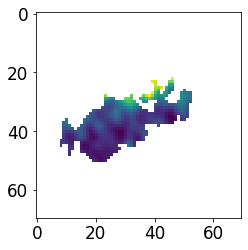

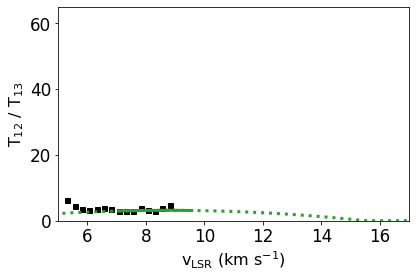

Guessing position angle of 98.03686933265251 deg
Blue PA: 66 deg deg, OA: 84 deg deg
Guessing position angle of -99.98420244040909 deg
Red PA: -1.1e+02 deg deg, OA: 1.1e+02 deg deg
CHECK THIS +++++++++++ 5.0 km / s [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False] [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True False False False
 False False False False False False Fals

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [3]:
ratio_list = [] 
ratio_rms_list = []
vsys_list = []
matplotlib.style.use('paper')
# physics_table = Table.read("physics_table_hops_def.txt", format='ascii')

# outflow_table = outflow_hops
# name = "hops"
# name = "davis"
for outflow_table, name in zip([outflow_davis, outflow_hops], ["davis", "hops"]):
    for i, row in enumerate(outflow_table):
#         iwork=0
#         if i != iwork:
#             continue
    #     davis = row["davis"]
    
        n = row[name]
        if name != "hops" or n != 158:
            continue
            
    #     if n != 30:
    #         continue

        blue_vel, red_vel = row["blue_vel"], row["red_vel"]
        tanabe = row["tanabe"]
        note = row["notes"]
        conf = row["outflow"]
        if conf == '?':
            conf = 'M'
        elif conf == '1':
            conf = 'D'

        if name == "davis":
            davis_row = table_davis[table_davis["SMZ"] == n][0]
            coord = SkyCoord(davis_row["_RAJ2000"], davis_row["_DEJ2000"], unit=u.deg)
        elif name == "hops":
            hops_row = table_hops[table_hops["HOPS"] == n][0]
            coord = SkyCoord(hops_row["RAJ2000"], hops_row["DEJ2000"], unit=u.deg)

        plot_dir = "{}{}_plots/".format(name, n)
        os.makedirs(plot_dir, exist_ok=True)

        # Read in the hand-drawn masks for the blue/red lobes.    
        width = height = u.Quantity(glob.glob("../masks/maskroi_{}{}*.npy".format(name, n))[0].split('_')[2])
        try:
            mask_blue = np.load(glob.glob("../masks/maskroi_{}{}_*blue.npy".format(name, n))[0])
            no_blue = False
        except IndexError:
            no_blue = True
            mask_blue = False
        try:       
            mask_red = np.load(glob.glob("../masks/maskroi_{}{}_*red.npy".format(name, n))[0])
            no_red = False
        except IndexError:
            no_red = True
            mask_red = False
        try:
            mask_full = np.load(glob.glob("../masks/maskroi_{}{}_*arcmin.npy".format(name, n))[0])
        except IndexError:
            mask_full = mask_blue + mask_red

        sub12 = extract_subcube(c12, region_class=RectangleSkyRegion,
                          region_kwargs=dict(center=coord, width=width, height=height))
        sub13 = extract_subcube(c13, region_class=RectangleSkyRegion,
                            region_kwargs=dict(center=coord, width=width, height=height))

        #PARSE BLUE/RED_VEL FROM TABLE
        #     print(blue_vel, red_vel)
        if blue_vel == '-':
            fit_12 = extract_subcube(sub12, CircleSkyRegion,
                                    region_kwargs={'center':coord, 'radius':15*u.arcsec})

            blue_vel, red_vel = calc_linewings(fit_12, nsigma_vel=2.)
            blue_vel, red_vel = blue_vel.to(u.km/u.s), red_vel.to(u.km/u.s)
        #         print(blue_vel, red_vel)
        else:
            try:
                blue_vel, red_vel = float(blue_vel)*u.km/u.s, float(red_vel)*u.km/u.s
            except ValueError:
                blue_vel, red_vel = blue_vel.strip("[]").split(','), red_vel.strip("[]").split(',')
                blue_vel = [float(a) for a in blue_vel]*u.km/u.s
                red_vel = [float(a) for a in red_vel]*u.km/u.s

        print(blue_vel, red_vel)

        #Calculate RMS in emission-free channels. Only consider pixels outside outflow mask.
        rms12 = rms(sub12.with_mask(~mask_full), velocity_range=[[-2,0],[18,20]]*u.km/u.s,
                   sigma_clipped=True)
        rms13 = rms(sub13.with_mask(~mask_full), velocity_range=[[0,2], [16,18]]*u.km/u.s,
                   sigma_clipped=True)
        print(rms12, rms13)


        #Use only the pixels with a integrated intensities > SNR set below in the 
        #visually defined velocity ranges.
        outflow_mom0_snr = 5.

        try:
            slab_blue = sub12.spectral_slab(sub12.spectral_extrema[0], blue_vel)
        except:
            slab_blue = sub12.spectral_slab(blue_vel[0], blue_vel[1])
        try:
            slab_red = sub12.spectral_slab(red_vel, sub12.spectral_extrema[1])
        except:
            slab_red = sub12.spectral_slab(red_vel[0], red_vel[1])

        mask_bluelobe = mask_blue & (slab_blue.moment0() > outflow_mom0_snr*sigma_mom0(slab_blue, channel_sigma=rms12))
        mask_redlobe = mask_red & (slab_red.moment0() > outflow_mom0_snr*sigma_mom0(slab_red, channel_sigma=rms12))
        mask_outflow = mask_bluelobe + mask_redlobe

        mask12_3sig = sub12 > 3*rms12
        mask13_3sig = sub13 > 3*rms13
        mask12_5sig = sub12 > 5*rms12
        mask13_5sig = sub13 > 5*rms13
        mask12_10sig = sub12 > 10*rms12
        mask13_10sig = sub13 > 10*rms13


        #Calculate Tex using the peak temperature of the average 12co spectrum.
        Tex_peak = cube_Tex(sub12.with_mask(mask_outflow), thick=True, plot="tex.png", average=True, average_first=True)
    #     !rm plot_dir
        
        plt.savefig(plot_dir + "Tex.pdf", bbox_inches='tight')
    #     plt.show()
        plt.clf()
        print(Tex_peak)
        print(name, n)

        #Fit the C18O spectrum with 1 or more gaussians to get the mean velocity of the cloud, or cloud components
        #along the line of sight.
        c18o_radius = 15*u.arcsec
        if n in [157,158]:
            print("HOPS {} is located outside of the C18O cube!\
            So I'm using the 13co in place of the C18O to fit for vsys.".format(n))
            sub18 = extract_subcube(c13, region_class=CircleSkyRegion,
                                            region_kwargs=dict(center=coord, radius=c18o_radius))
        else:
            sub18 = extract_subcube(c18, region_class=CircleSkyRegion,
                                            region_kwargs=dict(center=coord, radius=c18o_radius))

        spec18_mean = extract_spectrum(sub18, spectral_unit=u.km/u.s)

        spec18_gauss = fit_gaussian(spec18_mean.spectral_axis, spec18_mean, n_models=1, autoguess=True)
        try:
            vsys = np.sort([g.mean.value for g in spec18_gauss])*spec18_mean.spectral_axis.unit
        except TypeError:
            vsys = spec18_gauss.mean.value*spec18_mean.spectral_axis.unit

        plt.plot(spec18_mean.spectral_axis, spec18_mean, label=r"C$^{18}$O", color='black')
        plt.plot(spec18_mean.spectral_axis, spec18_gauss(spec18_mean.spectral_axis), label="Fit", color='tab:green', ls='-')
        plt.xlabel(r"v$_{\rm LSR}$ (km s$^{-1}$)")
        plt.ylabel(r"T$_{\rm MB}$ (K)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(plot_dir + "c18o_fit.pdf", bbox_inches='tight')
    #     plt.show()
        plt.clf()
        print("Fitted C18O cloud component(s) at", vsys)

        #Compute the velocity-dependent opacity correction. This could be fitting either a quadratic, or a 4-th order polynomial
        #if there are two distinct cloud components.
    #     fit_range = [vsys.value-2,vsys.value+2]*u.km/u.s
    #     fit_range = [2,18]*u.km/u.s
        if n == 160:
            fit_range = [5, 8]*u.km/u.s
        if n == 169:
            auto_range=False
            fit_range = [6.5, 7.5]*u.km/u.s
        elif n == 44:
            auto_range = False
            fit_range = [5, 9]*u.km/u.s
        elif n == 174:
            auto_range = False
            fit_range = [5, 8.5]*u.km/u.s
        else:
            auto_range=True
            fit_range = None

        print(vsys)
        sub12_correct, correctfactor = opacity_correct(sub12.with_mask(mask_outflow), 
                                                  sub13.with_mask(mask_outflow), rms_thick=rms12,
                                                  rms_thin=rms13, snr_cutoff=5., auto_range=auto_range, dv_range=1.5*u.km/u.s,
                                                  weighted_fit=True, fixed_fit=False, min_pix=0, plot_ylim=[0,65], plot_xlim=[5,17],
                                                  fit_func="parabola", vsys=vsys, fit_range=fit_range,    
                                                  plot_ratio=True, weighted_average=False, divide_std_by_n=True,
                                                  errorbar_kwargs=dict(markersize=5, marker='s', ls='', lw=1, zorder=0, color='black'),           
                                                  plot_kwargs=dict(c='tab:green'),
                                                  return_factor=True)
        plt.xlabel(r"v$_{\rm LSR}$ (km s$^{-1}$)")
        plt.savefig(plot_dir + "opacity_correct_divide_std_by_n.pdf",
                   bbox_inches='tight')
        plt.show()
        plt.clf()
        #Compute the mass spectrum in the outflow region
        #and integrate starting 1 km/s away from the peak(s) to get the total mass of the outflow.
        #the mass spectrum and masscube both have units of Msun / (km/s)
    #     dmdv_correct, masscube_correct = dmdv(sub12_correct, molecule='12co', Tex=Tex_peak,
    #                                          return_cube=True)


        #Fit the mass spectrum with n gaussians and subtract off the cloud spectrum.
        n_models = 1
        # print(dmdv_correct.spectral_axis)
        dv = 1*u.km/u.s


        #Calculate mass specturm and ambient cloud correction for each lobe individually. Then integrate
        #the mass spectrum at high velocities and add to the ambient-subtracted mass at low velocities.


        ### Compute Rmax and Vmax of lobes.
        if not no_blue:
            vmax_blue, _ = vmax_cube(sub12.with_mask(mask_bluelobe).with_mask(mask12_3sig), vsys=vsys, min_pixels=1, plot=True,
                                    plot_blue=True, plot_red=False, plot_kwargs=dict(color='tab:blue'))
            rmax_blue = rmax_cube(sub12.with_mask(mask_bluelobe), coord_zero=coord, dist=dist)
            tdyn_blue = (rmax_blue / vmax_blue).to(u.yr)
        if not no_red:
            _, vmax_red = vmax_cube(sub12.with_mask(mask_redlobe).with_mask(mask12_3sig), vsys=vsys, min_pixels=1, plot=True,
                                   plot_blue=False, plot_red=True, plot_kwargs=dict(color='tab:red'))
            rmax_red = rmax_cube(sub12.with_mask(mask_redlobe), coord_zero=coord, dist=dist)
            tdyn_red = (rmax_red / vmax_red).to(u.yr)
        plt.xlabel(r"v$_{\rm LSR}$ - v$_{\rm sys}$ (km s$^{-1}$)")
        plt.ylabel(r"T$_{\rm MB}$ (K)")
        plt.savefig(plot_dir + "vmax.pdf")
    #     plt.show()
        plt.clf()
        ### Compute outflow angles of lobes.  
        fig, ax = plt.subplots(1)
        if not no_blue:
    #         plt.imshow(mask_redlobe, origin='lower')
    #         plt.show()
    #         plt.clf()
            if n == 30:
                blue_pa = 20*u.deg
                e_blue_pa = np.nan*u.deg
                blue_oa = 120*u.deg
                e_blue_oa = np.nan*u.deg

            else:
                blue_pa, blue_oa, e_blue_pa, e_blue_oa = outflow_angles(
                    slab_blue.with_mask(mask_bluelobe), autoguess=True, pa_guess=None,
                    plot=True, plot_fwqm=True, plothist_kwargs=dict(facecolor='tab:blue', alpha=0.5),
                    plotfit_kwargs=dict(color='tab:blue'), plotfwqm_kwargs=dict(color='tab:blue', ls='dotted'),
                    bins=30, return_error=True, ax=ax)
            print("Blue PA: {:.2g} deg, OA: {:.2g} deg".format(blue_pa, blue_oa))
#         plt.savefig(plot_dir + "pa_blue.pdf")
#     #     plt.show()
#         plt.clf()

        if not no_red:
            red_pa, red_oa, e_red_pa, e_red_oa = outflow_angles(slab_red.with_mask(mask_redlobe), autoguess=True,
                       plot=True, plot_fwqm=True, plothist_kwargs=dict(facecolor='tab:red', alpha=0.5),
                        plotfit_kwargs=dict(color='tab:red'), plotfwqm_kwargs=dict(color='tab:red', ls='dotted'),
                       bins=30, return_error=True, ax=ax)
            print("Red PA: {:.2g} deg, OA: {:.2g} deg".format(red_pa, red_oa))
#         plt.savefig(plot_dir + "pa_red.pdf")
#     #     plt.show()
#         plt.clf()
        plt.savefig(plot_dir + "pa_both.pdf", bbox_inches='tight')
#     #     plt.show()
        plt.clf()

        if not no_blue:

            dmdv_correct_blue, masscube_correct_blue = dmdv(sub12_correct.with_mask(mask_bluelobe).with_mask(mask12_3sig),
                                                           molecule='12co',
                                                           Tex=Tex_peak, return_cube=True)
            dmdv_outflow_blue, dmdv_fit_blue = ambient_correct(dmdv_correct_blue, n_models=n_models, plot=False,
                                       autoguess=True, return_fit=True)

            ### If blue_vel is just one value, then this doesn't change it. This is for the cases where
            ### the visually determined blue_vel is a range of two velocities.
            blue_vel1 = np.max(blue_vel)

            M_blue_lowvel = sum_dmdv(dmdv_outflow_blue, vrange=[blue_vel1.value, (vsys-dv).value]*u.km/u.s,
                                        return_lobes=False, vsys=vsys)
            M_blue_hivel = sum_dmdv(dmdv_correct_blue, vrange=[-2, blue_vel1.value]*u.km/u.s,
                                   return_lobes=False, vsys=vsys)
            Mdot_blue_lowvel = (M_blue_lowvel / tdyn_blue).to(u.Msun/u.yr)
            Mdot_blue_hivel = (M_blue_hivel / tdyn_blue).to(u.Msun/u.yr)

            P_blue_lowvel = momentum_dmdv(dmdv_outflow_blue, vrange=[blue_vel1.value, (vsys-dv).value]*u.km/u.s,
                                         return_lobes=False, vsys=vsys)
            P_blue_hivel = momentum_dmdv(dmdv_correct_blue, vrange=[-2, blue_vel1.value]*u.km/u.s,
                                   return_lobes=False, vsys=vsys)
            Pdot_blue_lowvel = (P_blue_lowvel / tdyn_blue).to(u.Msun * u.km / (u.s * u.yr))
            Pdot_blue_hivel = (P_blue_hivel / tdyn_blue).to(u.Msun * u.km / (u.s * u.yr))

            E_blue_lowvel = energy_dmdv(dmdv_outflow_blue, vrange=[blue_vel1.value, (vsys-dv).value]*u.km/u.s,
                                         return_lobes=False, vsys=vsys)
            E_blue_hivel = energy_dmdv(dmdv_correct_blue, vrange=[-2, blue_vel1.value]*u.km/u.s,
                                   return_lobes=False, vsys=vsys)
            Edot_blue_lowvel = (E_blue_lowvel / tdyn_blue).to(u.erg/u.s)
            Edot_blue_hivel = (E_blue_hivel / tdyn_blue).to(u.erg/u.s)

            i_blue = dmdv_correct_blue.spectral_axis < vsys
            i_highvel = dmdv_correct_blue.spectral_axis <= blue_vel1
            i_lowvel = (dmdv_correct_blue.spectral_axis >= blue_vel1) & (dmdv_correct_blue.spectral_axis <= (vsys - 1*u.km/u.s))
    # #         print("vsys ", vsys)
            print("CHECK THIS +++++++++++", blue_vel, i_highvel, i_lowvel, tdyn_blue)
    #         print(M_blue_lowvel, M_blue_hivel)

            plt.plot(dmdv_correct_blue.spectral_axis[i_blue], dmdv_correct_blue[i_blue], color='tab:blue')
    #         plt.plot(dmdv_outflow_blue.spectral_axis[i_blue], dmdv_outflow_blue[i_blue], ls=':', color='tab:blue')
            x = np.linspace(dmdv_correct_blue.spectral_axis[i_lowvel][0].value, vsys.value, 100)
            plt.plot(x, dmdv_fit_blue(x*u.km/u.s).value,
                    color='black', ls='dashed', lw=1.5)
            plt.fill_between(dmdv_correct_blue.spectral_axis[i_highvel], dmdv_correct_blue[i_highvel],
                            color='tab:blue')
            plt.fill_between([dmdv_correct_blue.spectral_axis[i_highvel][-1].value, dmdv_correct_blue.spectral_axis[i_lowvel][0].value],
                             [dmdv_correct_blue[i_highvel][-1].value, dmdv_outflow_blue[i_lowvel][0].value], color='tab:blue')
            plt.fill_between(dmdv_outflow_blue.spectral_axis[i_lowvel], dmdv_outflow_blue[i_lowvel],
                            facecolor='tab:blue', alpha=0.4)
#             plt.fill_between(dmdv_correct_blue.spectral_axis[i_lowvel], dmdv_correct_blue[i_lowvel],
#                     dmdv_fit_blue(dmdv_correct_blue.spectral_axis[i_lowvel]),
#                     facecolor='tab:blue', alpha=0.4)

    #         plt.fill_between(dmdv_outflow_blue.spectral_axis[i_lowvel], dmdv_outflow_blue[i_lowvel],
    #                         facecolor='none', edgecolor='tab:blue', hatch='/')
            
        if not no_red:

            dmdv_correct_red, masscube_correct_red = dmdv(sub12_correct.with_mask(mask_redlobe).with_mask(mask12_3sig),
                                                          molecule='12co',
                                                          Tex=Tex_peak, return_cube=True)
            dmdv_outflow_red, dmdv_fit_red = ambient_correct(dmdv_correct_red, n_models=n_models, plot=False,
                                       autoguess=True,
    #                                    gaussian_kwargs=dict(amplitude=9*u.Msun/(u.km/u.s), mean=11*u.km/u.s, stddev=1*u.km/u.s),
                                       return_fit=True)
            print("red_vel = ", red_vel)
            ### If red_vel is just one value, then this doesn't change it. This is for the cases where
            ### the visually determined red_vel is a range of two velocities.
            red_vel1 = np.min(red_vel)

            M_red_lowvel = sum_dmdv(dmdv_outflow_red, vrange=[(vsys+dv).value, red_vel1.value]*u.km/u.s,
                                        return_lobes=False, vsys=vsys)
            M_red_hivel = sum_dmdv(dmdv_correct_red, vrange=[red_vel1.value, 20.]*u.km/u.s,
                                        return_lobes=False, vsys=vsys)
            Mdot_red_lowvel = (M_red_lowvel / tdyn_red).to(u.Msun/u.yr)
            Mdot_red_hivel = (M_red_hivel / tdyn_red).to(u.Msun/u.yr)
            print(M_red_lowvel, M_red_hivel)

            P_red_lowvel = momentum_dmdv(dmdv_outflow_red, vrange=[(vsys+dv).value, red_vel1.value]*u.km/u.s,
                                        return_lobes=False, vsys=vsys)
            P_red_hivel = momentum_dmdv(dmdv_correct_red, vrange=[red_vel1.value, 20.]*u.km/u.s,
                                        return_lobes=False, vsys=vsys)
            Pdot_red_lowvel = (P_red_lowvel / tdyn_red).to(u.Msun * u.km / (u.s * u.yr))
            Pdot_red_hivel = (P_red_hivel / tdyn_red).to(u.Msun * u.km / (u.s * u.yr))

            E_red_lowvel = energy_dmdv(dmdv_outflow_red, vrange=[(vsys+dv).value, red_vel1.value]*u.km/u.s,
                                        return_lobes=False, vsys=vsys)
            E_red_hivel = energy_dmdv(dmdv_correct_red, vrange=[red_vel1.value, 20.]*u.km/u.s,
                                        return_lobes=False, vsys=vsys)
            Edot_red_lowvel = (E_red_lowvel / tdyn_red).to(u.erg/u.s)
            Edot_red_hivel = (E_red_hivel / tdyn_red).to(u.erg/u.s)
    #         print("red_vel1", red_vel1) 
            i_red = dmdv_correct_red.spectral_axis > vsys
            i_highvel = dmdv_correct_red.spectral_axis >= red_vel1
            i_lowvel = (dmdv_correct_red.spectral_axis < red_vel1) & (dmdv_correct_red.spectral_axis > (vsys + 1*u.km/u.s))
            print(i_highvel, i_lowvel)
            plt.plot(dmdv_correct_red.spectral_axis[i_red], dmdv_correct_red[i_red], color='tab:red')
    #         plt.plot(dmdv_correct_red.spectral_axis, dmdv_correct_red, color='tab:red')
    #         plt.plot(dmdv_outflow_red.spectral_axis[i_red], dmdv_outflow_red[i_red], ls=':', color='tab:red')
            plt.plot(dmdv_correct_red.spectral_axis[i_lowvel], dmdv_fit_red(dmdv_correct_red.spectral_axis[i_lowvel]), ls='dashed', lw=1.5,
                    color='black')
    #         plt.plot(dmdv_correct_red.spectral_axis, dmdv_fit_red(dmdv_correct_red.spectral_axis),
    #                 color='black')
            plt.fill_between(dmdv_correct_red.spectral_axis[i_highvel], dmdv_correct_red[i_highvel],
                            color='tab:red')
    #         plt.fill_between(dmdv_correct_red.spectral_axis[i_lowvel], dmdv_correct_red[i_lowvel],
    #                         dmdv_fit_red(dmdv_correct_red.spectral_axis[i_lowvel]),
    #                         facecolor='tab:red', alpha=0.4)
            plt.fill_between(dmdv_outflow_red.spectral_axis[i_lowvel], dmdv_outflow_red[i_lowvel],
                            facecolor='tab:red', alpha=0.4)
        
            plt.fill_between([dmdv_correct_red.spectral_axis[i_lowvel][-1].value, dmdv_correct_red.spectral_axis[i_highvel][0].value],
                     [dmdv_outflow_red[i_lowvel][-1].value, dmdv_correct_red[i_highvel][0].value], color='tab:red')
#             print(dmdv_correct_red)
            x = np.linspace(dmdv_correct_red.spectral_axis[i_lowvel][0].value, vsys.value, 100)
            plt.plot(x, dmdv_fit_red(x*u.km/u.s).value,
                    color='black', ls='dashed', lw=1.5)




        print(coord)
        plt.semilogy()
    #     plt.xlim(-2, 20)
        
#         max([dmdv_correct_red[i_red].value, dmdv_correct_blue[i_blue])
             
        plt.gca().set_ylim(bottom=1e-4)
        plt.xlabel(r"v$_{LSR}$ (km s$^{-1}$)")
        plt.ylabel(r"dM/dv (M$_{\odot}$ [km s$^{-1}$]$^{-1}$)")
        plt.savefig(plot_dir + "dmdv.pdf", bbox_inches='tight')
    #     plt.show()
        plt.clf()        
        
        blue_levels = np.arange(5,55,5)*sigma_mom0(slab_blue, channel_sigma=rms12)
        red_levels = np.arange(5,55,5)*sigma_mom0(slab_red, channel_sigma=rms12)
        
        fig = plt.figure(figsize=(5,4))
        
        plot_finder(sub12, coord=coord,
                fit_cube=sub12, fig=fig,
                blue_vel=blue_vel.to(u.m/u.s), red_vel=red_vel.to(u.m/u.s),
                channel_sigma=None, fit_spectrum=False, show_vrange=False, show_fit=False,
                region_width=width, region_height=height,
                blue_levels=blue_levels, red_levels=red_levels,
                auto_sigma=False, sigma_contours=False,
                show_spectrum=False,
                catalogs=["/Users/jesse/repos/outflows/catalogs/hops.fits",
                          "/Users/jesse/repos/outflows/catalogs/davis09_h2jets.fits",
                          "/Users/jesse/repos/outflows/catalogs/spitzer_orion.fit"],
                catalog_kwargs=[dict(marker="s", s=15, color='black', lw=1, zorder=3),
                            dict(marker="+", s=70, color='black', lw=1, zorder=3),
                            dict(marker=".", s=7, color='black', lw=1, zorder=3)])
        ax = fig.axes[0]
        wcs = sub12.wcs.celestial
        x,y = wcs.all_world2pix(coord.ra, coord.dec, -1)
    #     print(xy)
    #     xy = coord.ra
        pix_pc = dist * sub12.header['CDELT2']*3600. / (206265)
    #     print(rmax_blue, pix_pc)
    
        if not no_blue:
            color='tab:blue'
            w_blue1= matplotlib.patches.Wedge(
                (x,y), (rmax_blue/pix_pc).value,
                (blue_pa-blue_oa/2).value+90, (blue_pa).value+90,
                alpha=0.2, facecolor=color, edgecolor=color)
            w_blue2= matplotlib.patches.Wedge(
                (x,y), (rmax_blue/pix_pc).value,
                (blue_pa).value+90, (blue_pa+blue_oa/2).value+90,
                alpha=0.2, facecolor=color, edgecolor=color)
            ax.add_patch(w_blue1)
            ax.add_patch(w_blue2)
            print(np.roll(slab_blue.with_mask(mask_blue).moment0().data,
                        (-1,-1), axis=(0,1)))
            contour_mask = np.nan_to_num(np.roll(slab_blue.with_mask(mask_blue).moment0().data,
                        (-1,-1), axis=(0,1)))
            ax.contour(contour_mask, levels=[blue_levels[0].value], colors=color)

        if not no_red:
            color='tab:red'
            w_red1= matplotlib.patches.Wedge(
                (x,y), (rmax_red/pix_pc).value,
                (red_pa-red_oa/2).value+90, (red_pa).value+90,
                alpha=0.2, facecolor=color, edgecolor=color)
            w_red2= matplotlib.patches.Wedge(
                (x,y), (rmax_red/pix_pc).value,
                (red_pa).value+90, (red_pa+red_oa/2).value+90,
                alpha=0.2, facecolor=color, edgecolor=color)
            ax.add_patch(w_red1)
            ax.add_patch(w_red2)
            contour_mask = np.nan_to_num(np.roll(slab_red.with_mask(mask_red).moment0().data,
                        (-1,-1), axis=(0,1)))
            ax.contour(contour_mask, levels=[red_levels[0].value], colors=color)
        
        show_filaments=True
        if show_filaments:
            t_fil = ascii.read("../closest_filament.txt")
            row = t_fil[t_fil["source"] == name+' '+str(n)]
            closest_fil = row["filament"][0]
            
            try:
                close_fils = row["within_10arcmin"][0].split()
            except AttributeError:
                close_fils = [closest_fil]
            for fil in close_fils:
                fil_file = "../../filaments/filaments_wcs/{}.txt".format(fil)
                fil_coords = ascii.read(fil_file)
                if fil == closest_fil:
                    color = 'black'
                else:
                    color = 'gray'
                ax.plot(fil_coords["RAJ2000"], fil_coords["DEJ2000"], ':',
                        color=color, linewidth=1,
                        transform=ax.get_transform('world'), zorder=3)

        plt.tight_layout()
        plt.savefig(plot_dir + "stamp.pdf", bbox_inches='tight')
        plt.clf()
        
        
        if not no_blue:
            table_row = dict(Source = "{} {}".format(name, n), Lobe = "B", PA = blue_pa.to(u.deg), e_PA = e_blue_pa.to(u.deg),
                            OA = blue_oa.to(u.deg), e_OA = e_blue_oa.to(u.deg),
                            RAJ2000 = coord.ra.to(u.deg), DEJ2000 = coord.dec.to(u.deg),
                            M_lowvel = M_blue_lowvel.to(u.Msun), M_hivel = M_blue_hivel.to(u.Msun),
                            P_lowvel = P_blue_lowvel.to(u.Msun*u.km/u.s), P_hivel = P_blue_hivel.to(u.Msun*u.km/u.s),
                            E_lowvel = E_blue_lowvel.to(u.erg), E_hivel = E_blue_hivel.to(u.erg),
                            vmax = vmax_blue.to(u.km/u.s), rmax = rmax_blue.to(u.pc), tdyn = tdyn_blue.to(u.yr),
                            Mdot_lowvel = Mdot_blue_lowvel.to(u.Msun/u.yr),
                            Mdot_hivel = Mdot_blue_hivel.to(u.Msun/u.yr),
                            Pdot_lowvel = Pdot_blue_lowvel.to(u.Msun*u.km/u.s/u.yr),
                            Pdot_hivel = Pdot_blue_hivel.to(u.Msun*u.km/u.s/u.yr),
                            Edot_lowvel = Edot_blue_lowvel.to(u.erg/u.s), 
                            Edot_hivel = Edot_blue_hivel.to(u.erg/u.s))

            physics_table.add_row(table_row)

    #         try:
    #             ind_row = np.where(physics_table[
    #                     (physics_table['Source'] == table_row['Source'])
    #                     & (physics_table['Lobe'] == table_row['Lobe'])])[0][0]

    #         except IndexError:
    #             ind_row = len(physics_table)-1
    #         physics_table.remove_row(ind_row)
    #         physics_table.insert_row(ind_row, table_row)

        if not no_red:
            table_row = dict(Source = "{} {}".format(name, n), Confidence = conf, Lobe = "R", PA = red_pa.to(u.deg), e_PA = e_red_pa.to(u.deg),
                            OA = red_oa.to(u.deg), e_OA = e_red_oa.to(u.deg),
                            RAJ2000 = coord.ra.to(u.deg), DEJ2000 = coord.dec.to(u.deg),
                            M_lowvel = M_red_lowvel.to(u.Msun), M_hivel = M_red_hivel.to(u.Msun),
                            P_lowvel = P_red_lowvel.to(u.Msun*u.km/u.s), P_hivel = P_red_hivel.to(u.Msun*u.km/u.s),
                            E_lowvel = E_red_lowvel.to(u.erg), E_hivel = E_red_hivel.to(u.erg),
                            vmax = vmax_red.to(u.km/u.s), rmax = rmax_red.to(u.pc), tdyn = tdyn_red.to(u.yr),
                            Mdot_lowvel = Mdot_red_lowvel.to(u.Msun/u.yr),
                            Mdot_hivel = Mdot_red_hivel.to(u.Msun/u.yr),
                            Pdot_lowvel = Pdot_red_lowvel.to(u.Msun*u.km/u.s/u.yr),
                            Pdot_hivel = Pdot_red_hivel.to(u.Msun*u.km/u.s/u.yr),
                            Edot_lowvel = Edot_red_lowvel.to(u.erg/u.s), 
                            Edot_hivel = Edot_red_hivel.to(u.erg/u.s))
            physics_table.add_row(table_row)

            
        
        

    #         try:
    #             ind_row = np.where(physics_table[
    #                     (physics_table['Source'] == table_row['Source'])
    #                     & (physics_table['Lobe'] == table_row['Lobe'])])[0][0]

    #         except IndexError:
    #             ind_row = len(physics_table)-1
    #         physics_table.remove_row(ind_row)
    #         physics_table.insert_row(ind_row, table_row)
            plt.clf()
        
        
print(physics_table)
physics_table.write(physics_table_name, format='ascii')

# physics_table = Table( 
#     names=["Source", "Lobe", "PA", "OA",
#            "RAJ2000", "DEJ2000", "M_lowvel", "M_hivel", "P_lowvel",
#            "P_hivel", "E_lowvel", "E_hivel",
#            "vmax", "rmax", "tdyn",
#            "Mdot_lowvel", "Mdot_hivel",
#            "Pdot_lowvel", "Pdot_hivel",
#            "Edot_lowvel", "Edot_hivel"], 
#     dtype=["str", "str", "f8", "f8",
#            "f8", "f8", "f8", "f8", "f8", "f8", "f8", "f8",
#            "f8", "f8", "f8", "f8", "f8", "f8", "f8", "f8", "f8"]) 

In [ ]:
physics_table.show_in_browser()
#     t = Table.read("physics_table.txt", format='ascii')
# t.show_in_browser(jsviewer=True)

In [5]:
a = ~sub12_correct.with_mask(mask12_3sig).apply_numpy_function(np.isnan)
np.count_nonzero(a, axis=(0,1))

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 183, 292, 429, 535, 722,
       848, 889, 883, 819, 822, 785, 704, 659, 607, 438, 425, 328, 221,
        63,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])